In [27]:
# script that processes CORUM data and integrates it with HuRI and BioPlex
import numpy
import scipy.stats
import math, itertools
import pandas, igraph
import huri_db_utils
from ccsblib.huri import *
import matplotlib.pyplot as plt
% matplotlib inline

import database_utils
connect = database_utils.get_connection()
cursor = connect.cursor()


In [15]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42  # TrueType fonts for ease of editing in illustrator
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 7.0
mpl.rcParams['savefig.dpi'] = 500


In [2]:
corum = load_corum_complexes()
corum.head()

,corum_complex_id,complex_name,subunits
0,1,BCL6-HDAC4 complex,"{ENSG00000113916, ENSG00000068024}"
1,2,BCL6-HDAC5 complex,"{ENSG00000113916, ENSG00000108840}"
2,3,BCL6-HDAC7 complex,"{ENSG00000113916, ENSG00000061273}"
3,4,Multisubunit ACTR coactivator complex,"{ENSG00000124151, ENSG00000005339, ENSG0000011..."
5,10,Condensin I complex,"{ENSG00000121152, ENSG00000109805, ENSG0000001..."


In [6]:
corum['num_prot'] = corum.apply(lambda x: len(x['subunits']), axis=1)
corum.head()
corum_filtered = corum.loc[corum['num_prot']>2,]
print(corum.shape)
print(corum_filtered.shape)


(2847, 4)
(1941, 4)


In [7]:
# build a set of corum complexes that don't overlap more than 90% -> choose larger complex and discard 
# smaller one of both that overlap more than 90%
# compute matrix with pairwise overlaps
# delete smaller complex of largest overlaps and iterate until the largest overlap is below 90%
overlaps = numpy.zeros((corum_filtered.shape[0],corum_filtered.shape[0]),dtype=float)
for i in range(corum_filtered.shape[0]):
    if i % 100 == 0:
        print(i)
    for j in range(corum_filtered.shape[0]):
        if i != j:
            overlaps[i,j] = len(corum_filtered.iloc[i,2].intersection(corum_filtered.iloc[j,2]))/float(len(corum_filtered.iloc[i,2]))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [8]:
outfile = '../data/katjas_data/corum_analysis/corum_complex_overlap_matrix.npy'
numpy.save(outfile,overlaps)

In [9]:
overlaps = numpy.load(outfile)
overlaps.shape

(1941, 1941)

In [10]:
cutoff = 0.9
max_overlap = overlaps.max()
ind = numpy.unravel_index(numpy.argmax(overlaps, axis=None), overlaps.shape)
count = 0
while max_overlap >= cutoff:
    overlaps[ind[0]] = -1
    max_overlap = overlaps.max()
    ind = numpy.unravel_index(numpy.argmax(overlaps, axis=None), overlaps.shape)
    count += 1
    if count % 100 == 0:
        print(count)


100
200
300
400
500


In [11]:
outfile = '../data/katjas_data/corum_analysis/filtered_corum_complexes_0.9.txt'
target = open(outfile,'w')
target.write('ComplexID\tComplexName\tComplexSubunits\n')
for i in range(overlaps.shape[0]):
    if overlaps[i].min() >= 0:
        target.write(str(corum_filtered.iloc[i,0]) + '\t' + corum_filtered.iloc[i,1] + '\t' + '|'.join(list(corum_filtered.iloc[i,2])) + '\n')
target.close()        

In [12]:
hi_iii = huri_db_utils.load_nw_hi_iii(id_type='ensembl_gene_id',fmt='igraph',cache='off')
for edge in hi_iii.es:
    if edge['in_screen_1'] == True:
        edge['in_screen_1'] = 1
    else:
        edge['in_screen_1'] = 0
    if edge['in_screen_2'] == True:
        edge['in_screen_2'] = 1
    else:
        edge['in_screen_2'] = 0
    if edge['in_screen_3'] == True:
        edge['in_screen_3'] = 1
    else:
        edge['in_screen_3'] = 0
    if edge['in_screen_4'] == True:
        edge['in_screen_4'] = 1
    else:
        edge['in_screen_4'] = 0
    if edge['in_screen_5'] == True:
        edge['in_screen_5'] = 1
    else:
        edge['in_screen_5'] = 0
    if edge['in_screen_6'] == True:
        edge['in_screen_6'] = 1
    else:
        edge['in_screen_6'] = 0
    if edge['in_screen_7'] == True:
        edge['in_screen_7'] = 1
    else:
        edge['in_screen_7'] = 0
    if edge['in_screen_8'] == True:
        edge['in_screen_8'] = 1
    else:
        edge['in_screen_8'] = 0
    if edge['in_screen_9'] == True:
        edge['in_screen_9'] = 1
    else:
        edge['in_screen_9'] = 0

In [13]:
# test whether HI-III-2ev tends to contain more co-complex PPIs than HI-III-1ev
# get the filtered corum data
infile = '../data/katjas_data/corum_analysis/filtered_corum_complexes_0.9.txt'
file1 = open(infile,'r')
entries = file1.readlines()
file1.close()
# get a dict gene -> complex ids
complex_member_dict = {}
for line in entries[1:]:
    tab_list = str.split(line[:-1],'\t')
    complex_id = int(tab_list[0])
    subunits = tab_list[2].split('|')
    for gene in subunits:
        if gene not in complex_member_dict:
            complex_member_dict[gene] = set()
        complex_member_dict[gene].add(complex_id)

C_2ev_count = 0
C_not_2ev_count = 0
notC_2ev_count = 0
notC_not_2ev_count = 0
for edge in hi_iii.es:
    gene_a = hi_iii.vs[edge.source]['name']
    gene_b = hi_iii.vs[edge.target]['name']
    # is pair in common gene space of HI-III and Corum?
    if edge.source != edge.target and gene_a in complex_member_dict and gene_b in complex_member_dict:
        num_screens = sum([edge['in_screen_1'],edge['in_screen_2'],edge['in_screen_3'],edge['in_screen_4'],edge['in_screen_5'],edge['in_screen_6'],edge['in_screen_7'],edge['in_screen_8'],edge['in_screen_9']])
        # is PPI in a corum complex
        if len(complex_member_dict[gene_a].intersection(complex_member_dict[gene_b])) > 0:
            C = True
        else:
            C = None
        if num_screens > 1 and C:
            C_2ev_count += 1
        elif num_screens > 1 and not C:
            notC_2ev_count += 1
        elif num_screens == 1 and C:
            C_not_2ev_count += 1
        else:
            notC_not_2ev_count += 1

cont_table = [[C_2ev_count,C_not_2ev_count],[notC_2ev_count,notC_not_2ev_count]]
print(cont_table)
print(scipy.stats.fisher_exact(cont_table))

[[232, 137], [543, 905]]
(2.8223844282238444, 3.0644660122597765e-18)


In [14]:
# generate suppl table
outfile = '../data/katjas_data/corum_analysis/corum_huri.txt'
target = open(outfile,'w')
target.write('Ensembl_gene_id_a\tEnsembl_gene_id_b\tin_complex\tbetween_complex\tnumber_screens\n')
for edge in hi_iii.es:
    gene_a = hi_iii.vs[edge.source]['name']
    gene_b = hi_iii.vs[edge.target]['name']
    # is pair in common gene space of HI-III and Corum?
    if edge.source != edge.target and gene_a in complex_member_dict and gene_b in complex_member_dict:
        num_screens = sum([edge['in_screen_1'],edge['in_screen_2'],edge['in_screen_3'],edge['in_screen_4'],edge['in_screen_5'],edge['in_screen_6'],edge['in_screen_7'],edge['in_screen_8'],edge['in_screen_9']])
        # is PPI in a corum complex
        if len(complex_member_dict[gene_a].intersection(complex_member_dict[gene_b])) > 0:
            C = True
        else:
            C = None
        if num_screens > 1 and C:
            C_2ev_count += 1
        elif num_screens > 1 and not C:
            notC_2ev_count += 1
        elif num_screens == 1 and C:
            C_not_2ev_count += 1
        else:
            notC_not_2ev_count += 1
        target.write(sorted([gene_a,gene_b])[0] + '\t' + sorted([gene_a,gene_b])[1] + '\t')
        if C:
            target.write('1\t0\t' + str(num_screens) + '\n')
        else:
            target.write('0\t1\t' + str(num_screens) + '\n')
target.close()


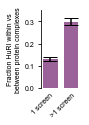

In [16]:
# plot the fractions of overlap of HI-III-2ev and 1ev with CORUM
plt.figure(figsize=(1.25,1.75))
values = [137/float(137+905),232/float(232+543)]
yerr = [numpy.sqrt((values[0]*(1-values[0]))/float(137+905)),numpy.sqrt((values[1]*(1-values[1]))/float(232+543))]
plt.bar([1,2],values,yerr=yerr,color=(155/255, 97/255, 153/255),capsize=7,width=0.7)
plt.xticks([0.6,1.6],['1 screen','>1 screen'],rotation=45)
plt.ylabel('Fraction HuRI within vs\nbetween protein complexes')
plt.ylim([0,0.35])
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_tick_params(length=0.)
plt.tight_layout()

filename = '../figures/HI-III-1ev_2ev_CORUM_overlap'
outfile = filename + '.png'
plt.savefig(outfile,fmt='png',dpi=300)
outfile = filename + '.pdf'
plt.savefig(outfile,fmt='pdf',dpi=300)

plt.show()

In [31]:
# draw all CORUM complexes with BioPlex and HuRI edges
corum_file = '../data/katjas_data/corum_analysis/filtered_corum_complexes_0.9.txt'
corum = pandas.read_table(corum_file)
corum.head()

,ComplexID,ComplexName,ComplexSubunits
0,4,Multisubunit ACTR coactivator complex,ENSG00000124151|ENSG00000005339|ENSG0000011416...
1,27,Arp2/3 protein complex,ENSG00000138071|ENSG00000162704|ENSG0000011509...
2,41,Mi-2/NuRD-MTA3 complex,ENSG00000113916|ENSG00000071655|ENSG0000014948...
3,49,DNMT3B complex,ENSG00000090889|ENSG00000088305|ENSG0000015314...
4,50,RAB5-RABAPTIN5\u2013RABEX5 complex,ENSG00000029725|ENSG00000154710|ENSG00000144566


In [18]:
corum['num_pairs'] = [numpy.NaN for i in range(corum.shape[0])]
corum['num_hi_ppis'] = [numpy.NaN for i in range(corum.shape[0])]
corum['num_bp_ppis'] = [numpy.NaN for i in range(corum.shape[0])]
print(corum.shape)
corum.head()

(1346, 6)


,ComplexID,ComplexName,ComplexSubunits,num_pairs,num_hi_ppis,num_bp_ppis
0,4,Multisubunit ACTR coactivator complex,ENSG00000114166|ENSG00000005339|ENSG0000010039...,NaN,NaN,NaN
1,27,Arp2/3 protein complex,ENSG00000163466|ENSG00000111229|ENSG0000024155...,NaN,NaN,NaN
2,41,Mi-2/NuRD-MTA3 complex,ENSG00000071655|ENSG00000116478|ENSG0000014948...,NaN,NaN,NaN
3,49,DNMT3B complex,ENSG00000153147|ENSG00000116478|ENSG0000008830...,NaN,NaN,NaN
4,50,RAB5-RABAPTIN5\u2013RABEX5 complex,ENSG00000144566|ENSG00000154710|ENSG00000029725,NaN,NaN,NaN


In [20]:
bioplex_df = load_nw_bioplex(id_type='ensembl_gene_id')
bioplex = set(list(bioplex_df.itertuples(index=False,name=None)))
bioplex_df.head()

,ensembl_gene_id_a,ensembl_gene_id_b
0,ENSG00000196604,ENSG00000196839
1,ENSG00000123684,ENSG00000196604
2,ENSG00000109971,ENSG00000123684
3,ENSG00000123684,ENSG00000169067
4,ENSG00000123684,ENSG00000182264


In [21]:
hi_iii_df = load_nw_hi_iii(id_type='ensembl_gene_id')
hi_iii = set(list(hi_iii_df[['ensembl_gene_id_a','ensembl_gene_id_b']].itertuples(index=False,name=None)))
hi_iii_df.head()

,ensembl_gene_id_a,ensembl_gene_id_b,in_assay_v1,in_assay_v2,in_assay_v6,in_screen_1,in_screen_2,in_screen_3,in_screen_4,in_screen_5,in_screen_6,in_screen_7,in_screen_8,in_screen_9
0,ENSG00000000005,ENSG00000061656,False,True,False,False,False,False,False,False,True,False,False,False
1,ENSG00000000005,ENSG00000099968,False,True,False,False,False,False,False,True,False,False,False,False
2,ENSG00000000005,ENSG00000104765,True,False,False,False,False,True,False,False,False,False,False,False
3,ENSG00000000005,ENSG00000105383,False,False,True,False,False,False,False,False,False,False,False,True
4,ENSG00000000005,ENSG00000114455,False,False,True,False,False,False,False,False,False,False,False,True


In [23]:
query = """select distinct ensembl_gene_id_short,symbol
            from horfeome_annotation_gencode27.gencode2entrez"""
cursor.execute(query)
rows = cursor.fetchall()
symbol_dict = dict(rows)

In [29]:
nodes = []
edges = []
source_attr = []
ensembl_gene_ids = []
corum_ids = []
symbols = []
num_evidences = []

for index,row in corum.iterrows():
    gene_ids = row['ComplexSubunits'].split('|')
    complex_id = row['ComplexID']
    pairs = [tuple(sorted(list(t))) for t in itertools.combinations(row['ComplexSubunits'].split('|'),2)]
    pairs_set = set(pairs)
    hi_iii_pairs = pairs_set.intersection(hi_iii)
    bioplex_pairs = pairs_set.intersection(bioplex)
    if len(hi_iii_pairs) > 0 and len(bioplex_pairs) > 0:
        sources = ['corum' for i in range(len(pairs))]
        new_evidences = [0 for i in range(len(pairs))]
        for pair in hi_iii_pairs:
            sources[pairs.index(pair)] = 'hi_iii'
            row = hi_iii_df.loc[(hi_iii_df['ensembl_gene_id_a']==pair[0]) & (hi_iii_df['ensembl_gene_id_b']==pair[1]),
                          ['in_screen_1','in_screen_2','in_screen_3','in_screen_4','in_screen_5','in_screen_6','in_screen_7','in_screen_8','in_screen_9',]]
            new_evidences[pairs.index(pair)] = len(list(filter(lambda v: v,row.iloc[0,].tolist())))
        pairs_names = [(t[0] + '_' + str(complex_id),t[1] + '_' + str(complex_id)) for t in pairs]
        for pair in bioplex_pairs:
            if sources[pairs.index(pair)] == 'corum':
                sources[pairs.index(pair)] = 'bioplex'
            else:
                sources.append('bioplex')
                pairs_names.append((pair[0] + '_' + str(complex_id),pair[1] + '_' + str(complex_id)))
                new_evidences.append(0)

        ensembl_gene_ids = ensembl_gene_ids + gene_ids
        corum_ids = corum_ids + [complex_id for i in range(len(gene_ids))]
        symbols = symbols + [(symbol_dict[gene_id] if gene_id in symbol_dict else gene_id) for gene_id in gene_ids]
        names = [gene_id + '_' + str(complex_id) for gene_id in gene_ids]
        nodes = nodes + names
        edges = edges + pairs_names
        source_attr = source_attr + sources
        num_evidences = num_evidences + new_evidences

g = igraph.Graph()
g.add_vertices(nodes)
g.add_edges(edges)
g.es['origin'] = source_attr
g.es['num_hi_evidences'] = num_evidences
g.vs['ensembl_gene_id'] = ensembl_gene_ids
g.vs['complex_id'] = corum_ids
g.vs['symbols'] = symbols
    

In [30]:
corum_style = {'title': 'corum_style',
 'defaults': [{'visualProperty': 'COMPOUND_NODE_PADDING', 'value': 10.0},
  {'visualProperty': 'COMPOUND_NODE_SHAPE', 'value': 'ROUND_RECTANGLE'},
  {'visualProperty': 'DING_RENDERING_ENGINE_ROOT',
   'value': 'org.cytoscape.view.presentation.property.NullVisualProperty$NullDataTypeImpl@2db2d86c'},
  {'visualProperty': 'EDGE',
   'value': 'DefaultVisualizableVisualProperty(id=EDGE, name=Edge Visual Property)'},
  {'visualProperty': 'EDGE_BEND', 'value': ''},
  {'visualProperty': 'EDGE_CURVED', 'value': True},
  {'visualProperty': 'EDGE_LABEL', 'value': ''},
  {'visualProperty': 'EDGE_LABEL_COLOR', 'value': '#333333'},
  {'visualProperty': 'EDGE_LABEL_FONT_FACE', 'value': 'Dialog,plain,10'},
  {'visualProperty': 'EDGE_LABEL_FONT_SIZE', 'value': 10},
  {'visualProperty': 'EDGE_LABEL_TRANSPARENCY', 'value': 255},
  {'visualProperty': 'EDGE_LABEL_WIDTH', 'value': 200.0},
  {'visualProperty': 'EDGE_LINE_TYPE', 'value': 'SOLID'},
  {'visualProperty': 'EDGE_PAINT', 'value': '#323232'},
  {'visualProperty': 'EDGE_SELECTED', 'value': False},
  {'visualProperty': 'EDGE_SELECTED_PAINT', 'value': '#FF0000'},
  {'visualProperty': 'EDGE_SOURCE_ARROW_SELECTED_PAINT', 'value': '#FFFF00'},
  {'visualProperty': 'EDGE_SOURCE_ARROW_SHAPE', 'value': 'NONE'},
  {'visualProperty': 'EDGE_SOURCE_ARROW_SIZE', 'value': 6.0},
  {'visualProperty': 'EDGE_SOURCE_ARROW_UNSELECTED_PAINT', 'value': '#000000'},
  {'visualProperty': 'EDGE_STROKE_SELECTED_PAINT', 'value': '#FF0000'},
  {'visualProperty': 'EDGE_STROKE_UNSELECTED_PAINT', 'value': '#999999'},
  {'visualProperty': 'EDGE_TARGET_ARROW_SELECTED_PAINT', 'value': '#FFFF00'},
  {'visualProperty': 'EDGE_TARGET_ARROW_SHAPE', 'value': 'NONE'},
  {'visualProperty': 'EDGE_TARGET_ARROW_SIZE', 'value': 6.0},
  {'visualProperty': 'EDGE_TARGET_ARROW_UNSELECTED_PAINT', 'value': '#000000'},
  {'visualProperty': 'EDGE_TOOLTIP', 'value': ''},
  {'visualProperty': 'EDGE_TRANSPARENCY', 'value': 255},
  {'visualProperty': 'EDGE_UNSELECTED_PAINT', 'value': '#404040'},
  {'visualProperty': 'EDGE_VISIBLE', 'value': True},
  {'visualProperty': 'EDGE_WIDTH', 'value': 3.0},
  {'visualProperty': 'NETWORK',
   'value': 'DefaultVisualizableVisualProperty(id=NETWORK, name=Network Visual Property)'},
  {'visualProperty': 'NETWORK_BACKGROUND_PAINT', 'value': '#FFFFFF'},
  {'visualProperty': 'NETWORK_CENTER_X_LOCATION', 'value': 0.0},
  {'visualProperty': 'NETWORK_CENTER_Y_LOCATION', 'value': 0.0},
  {'visualProperty': 'NETWORK_CENTER_Z_LOCATION', 'value': 0.0},
  {'visualProperty': 'NETWORK_DEPTH', 'value': 0.0},
  {'visualProperty': 'NETWORK_EDGE_SELECTION', 'value': True},
  {'visualProperty': 'NETWORK_HEIGHT', 'value': 400.0},
  {'visualProperty': 'NETWORK_NODE_SELECTION', 'value': True},
  {'visualProperty': 'NETWORK_SCALE_FACTOR', 'value': 1.0},
  {'visualProperty': 'NETWORK_SIZE', 'value': 550.0},
  {'visualProperty': 'NETWORK_TITLE', 'value': ''},
  {'visualProperty': 'NETWORK_WIDTH', 'value': 550.0},
  {'visualProperty': 'NODE',
   'value': 'DefaultVisualizableVisualProperty(id=NODE, name=Node Visual Property)'},
  {'visualProperty': 'NODE_BORDER_PAINT', 'value': '#000000'},
  {'visualProperty': 'NODE_BORDER_STROKE', 'value': 'SOLID'},
  {'visualProperty': 'NODE_BORDER_TRANSPARENCY', 'value': 255},
  {'visualProperty': 'NODE_BORDER_WIDTH', 'value': 0.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_1',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_2',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_3',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_4',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_5',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_6',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_7',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_8',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_9',
   'value': 'org.cytoscape.ding.customgraphics.NullCustomGraphics,0,[ Remove Graphics ],'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_1',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_2',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_3',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_4',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_5',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_6',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_7',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_8',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_POSITION_9',
   'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_1', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_2', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_3', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_4', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_5', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_6', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_7', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_8', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMGRAPHICS_SIZE_9', 'value': 50.0},
  {'visualProperty': 'NODE_CUSTOMPAINT_1',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_1, name=Node Custom Paint 1)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_2',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_2, name=Node Custom Paint 2)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_3',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_3, name=Node Custom Paint 3)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_4',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_4, name=Node Custom Paint 4)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_5',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_5, name=Node Custom Paint 5)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_6',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_6, name=Node Custom Paint 6)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_7',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_7, name=Node Custom Paint 7)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_8',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_8, name=Node Custom Paint 8)'},
  {'visualProperty': 'NODE_CUSTOMPAINT_9',
   'value': 'DefaultVisualizableVisualProperty(id=NODE_CUSTOMPAINT_9, name=Node Custom Paint 9)'},
  {'visualProperty': 'NODE_DEPTH', 'value': 0.0},
  {'visualProperty': 'NODE_FILL_COLOR', 'value': '#C3E4FF'},
  {'visualProperty': 'NODE_HEIGHT', 'value': 30.0},
  {'visualProperty': 'NODE_LABEL', 'value': ''},
  {'visualProperty': 'NODE_LABEL_COLOR', 'value': '#333333'},
  {'visualProperty': 'NODE_LABEL_FONT_FACE', 'value': 'Dialog,plain,12'},
  {'visualProperty': 'NODE_LABEL_FONT_SIZE', 'value': 10},
  {'visualProperty': 'NODE_LABEL_POSITION', 'value': 'C,C,c,0.00,0.00'},
  {'visualProperty': 'NODE_LABEL_TRANSPARENCY', 'value': 255},
  {'visualProperty': 'NODE_LABEL_WIDTH', 'value': 200.0},
  {'visualProperty': 'NODE_NESTED_NETWORK_IMAGE_VISIBLE', 'value': True},
  {'visualProperty': 'NODE_PAINT', 'value': '#787878'},
  {'visualProperty': 'NODE_SELECTED', 'value': False},
  {'visualProperty': 'NODE_SELECTED_PAINT', 'value': '#FFFF00'},
  {'visualProperty': 'NODE_SHAPE', 'value': 'ELLIPSE'},
  {'visualProperty': 'NODE_SIZE', 'value': 25.0},
  {'visualProperty': 'NODE_TOOLTIP', 'value': ''},
  {'visualProperty': 'NODE_TRANSPARENCY', 'value': 255},
  {'visualProperty': 'NODE_VISIBLE', 'value': True},
  {'visualProperty': 'NODE_WIDTH', 'value': 70.0},
  {'visualProperty': 'NODE_X_LOCATION', 'value': 0.0},
  {'visualProperty': 'NODE_Y_LOCATION', 'value': 0.0},
  {'visualProperty': 'NODE_Z_LOCATION', 'value': 0.0}],
 'mappings': [{'mappingType': 'discrete',
   'mappingColumn': 'num_hi_evidences',
   'mappingColumnType': 'Double',
   'visualProperty': 'EDGE_WIDTH',
   'map': [{'key': '0.0', 'value': '3.0'},
    {'key': '1.0', 'value': '3.0'},
    {'key': '2.0', 'value': '6.0'},
    {'key': '4.0', 'value': '6.0'},
    {'key': '8.0', 'value': '6.0'},
    {'key': '9.0', 'value': '6.0'},
    {'key': '5.0', 'value': '6.0'},
    {'key': '3.0', 'value': '6.0'},
    {'key': '6.0', 'value': '6.0'},
    {'key': '7.0', 'value': '6.0'}]},
  {'mappingType': 'discrete',
   'mappingColumn': 'origin',
   'mappingColumnType': 'String',
   'visualProperty': 'EDGE_STROKE_UNSELECTED_PAINT',
   'map': [{'key': 'corum', 'value': '#FFFFFF'},
    {'key': 'hi_iii', 'value': '#9B6199'},
    {'key': 'bioplex', 'value': '#E6550D'}]},
  {'mappingType': 'passthrough',
   'mappingColumn': 'interaction',
   'mappingColumnType': 'String',
   'visualProperty': 'EDGE_LABEL'},
  {'mappingType': 'discrete',
   'mappingColumn': 'interaction',
   'mappingColumnType': 'String',
   'visualProperty': 'EDGE_LINE_TYPE',
   'map': [{'key': 'pp', 'value': 'SOLID'},
    {'key': 'pd', 'value': 'LONG_DASH'}]},
  {'mappingType': 'passthrough',
   'mappingColumn': 'symbols',
   'mappingColumnType': 'String',
   'visualProperty': 'NODE_LABEL'},
  {'mappingType': 'discrete',
   'mappingColumn': 'origin',
   'mappingColumnType': 'String',
   'visualProperty': 'EDGE_TRANSPARENCY',
   'map': [{'key': 'corum', 'value': '0'},
    {'key': 'bioplex', 'value': '100'},
    {'key': 'hi_iii', 'value': '255'}]}]}

In [33]:
PORT_NUMBER = 1234
IP = 'localhost'
BASE = 'http://' + IP + ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type':'application/json'}
from py2cytoscape.data.cyrest_client import CyRestClient
cy = CyRestClient()
cy.session.delete()
g_name = 'CORUM_HI_BP'
style_obj = cy.style.create(name='corum_style',original_style=corum_style)

network = cy.network.create_from_igraph(g,name=g_name)
cy.layout.apply(name='force-directed', network=network)
cy.style.apply(style_obj,network=network)
pdf = network.get_pdf()
target = open('../data/katjas_data/corum_analysis/' + g_name + '.network.pdf','wb')
target.write(pdf)
target.close()


In [38]:
import py2cytoscape
dir(py2cytoscape)

['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'data',
 'util']

In [45]:
py2cytoscape.__builtins__

{'__name__': 'builtins',
 '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
 '__package__': '',
 '__loader__': _frozen_importlib.BuiltinImporter,
 '__spec__': ModuleSpec(name='builtins', loader=<class '_frozen_importlib.BuiltinImporter'>),
 '__build_class__': <function __build_class__>,
 '__import__': <function __import__>,
 'abs': <function abs(x, /)>,
 'all': <function all(iterable, /)>,
 'any': <function any(iterable, /)>,
 'ascii': <function ascii(obj, /)>,
 'bin': <function bin(number, /)>,
 'breakpoint': <function breakpoint>,
 'callable': <function callable(obj, /)>,
 'chr': <function chr(i, /)>,
 'compile': <function compile(source, filename, mode, flags=0, dont_inherit=False, optimize=-1)>,
 'delattr': <function delattr(obj, name, /)>,
 'dir': <function dir>,
 'divmod': <function divmod(x, y, /)>,
 'eval': <function eval(source, globals=None, locals=None, /)>,
 'exec': <function exec(s